# Downscale 8 upper atm variables to Surface Gridmet

This notebook calculates weather on a 128x128 grid given 8 upper atm variables, via a CNN pre-trained model.


### TODO items

* better graphs
* load netcdf files directly (currently loads numpy files)



In [1]:
from IPython import display

import numpy as np
import torch
from torch import nn
from torch.optim import Adam
from torch.autograd import Variable

import cv2
#from skimage.metrics import structural_similarity as ssim
import copy


In [2]:
# define internal pic res
ires = 128
res = 128
nvars = 8
mnvars = 8*1 +1


In [3]:
 mnvars

9

In [6]:

class GenerativeNet(torch.nn.Module):
    """Encoder"""
    def __init__(self):
        super(GenerativeNet, self).__init__()

        self.conv11 = nn.Sequential(
            #nn.BatchNorm2d(mnvars),
            nn.Conv2d(
                in_channels=mnvars, out_channels=128, kernel_size=4,
                stride=2, padding=1, bias=True
            ),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.conv22 = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Conv2d(
                in_channels=128, out_channels=256, kernel_size=4,
                stride=2, padding=1, bias=True
            ),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.conv33 = nn.Sequential(
            nn.BatchNorm2d(256),
            nn.Conv2d(
                in_channels=256, out_channels=512, kernel_size=4,
                stride=2, padding=1, bias=True
            ),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.conv44 = nn.Sequential(
            nn.BatchNorm2d(512),
            nn.Conv2d(
                in_channels=512, out_channels=1024, kernel_size=4,
                stride=2, padding=1, bias=True
            ),
            nn.LeakyReLU(0.2, inplace=True)
        )

        self.conv55 = nn.Sequential(
            nn.BatchNorm2d(1024),
            nn.Conv2d(
                in_channels=1024, out_channels=2048, kernel_size=4,
                stride=2, padding=1, bias=True
            ),
            nn.LeakyReLU(0.2, inplace=True)
        )


    def forward(self, x):
        # Project and reshape
        #x = self.linear(x)
        #x1 = x.view(x.shape[0], mnvars, ires, ires)

        #m = nn.Dropout(p=0.1)
        #x1 = m(x1)

        # Convolutional layers
        x = self.conv11(x)
        x = self.conv22(x)
        x = self.conv33(x)
        x = self.conv44(x)
        x = self.conv55(x)
        
        return x
    
    
    
    
class GenerativeNet2(torch.nn.Module):
    """Decoder"""
    def __init__(self):
        super(GenerativeNet2, self).__init__()

        self.conv1 = nn.Sequential(
            nn.BatchNorm2d(2048),
            nn.ConvTranspose2d(
                in_channels=2048, out_channels=1024, kernel_size=4,
                stride=2, padding=1, bias=True
            ),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.BatchNorm2d(1024),
            nn.ConvTranspose2d(
                in_channels=1024, out_channels=512, kernel_size=4,
                stride=2, padding=1, bias=True
            ),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.conv3 = nn.Sequential(
            nn.BatchNorm2d(512),
            nn.ConvTranspose2d(
                in_channels=512, out_channels=256, kernel_size=4,
                stride=2, padding=1, bias=True
            ),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.conv4 = nn.Sequential(
            nn.BatchNorm2d(256),
            nn.ConvTranspose2d(
                in_channels=256, out_channels=128, kernel_size=4,
                stride=2, padding=1, bias=True
            ),
            nn.LeakyReLU(0.2, inplace=True)
        )

        self.conv5 = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.ConvTranspose2d(
                in_channels=128, out_channels=mnvars, kernel_size=4,
                stride=2, padding=1, bias=True
            ),
            #nn.BatchNorm2d(512),
            #nn.LeakyReLU(0.2, inplace=True)
            nn.Sigmoid() # constrain output to 0-1 b/c SSIM does not like them
        )

    def forward(self, x):
        # Convolutional layers
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        ## Flatten and apply sigmoid
        #x = x.view(-1, 2048*4*4)
        #x = self.out(x)
        return x



In [67]:
# load autoencoder
generator = GenerativeNet()
generator2 = GenerativeNet2()
generator3 = GenerativeNet2()
#gstate = torch.load("/glade/scratch/dkorytin/saved_models/autoencoder-uatm128-eraandmpi-with-doy-cuda_generator-e450", map_location=torch.device('cuda:0'))
gstate = torch.load("/glade/scratch/dkorytin/saved_models/autoencoder-uatm128-eraandmpi-with-doy-cuda_generator-e450", map_location=torch.device('cpu'))
minmaxo = gstate['minmaxo']
minmaxi_era = np.array(gstate['minmaxi_era'])
minmaxi_mpi = np.array(gstate['minmaxi_mpi'])

generator.load_state_dict(gstate['generator'])
generator.eval()

generator2.load_state_dict(gstate['generator2'])
generator2.eval()

generator3.load_state_dict(gstate['generator3'])
generator3.eval()



GenerativeNet2(
  (conv1): Sequential(
    (0): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): ConvTranspose2d(2048, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (conv2): Sequential(
    (0): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (conv3): Sequential(
    (0): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (conv4): Sequential(
    (0): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (2): Lea

# Load output gridmet data (to verify agaist if wanted)

In [200]:
##################
## LOAD GRIDMET ##
##################
# 1980-1989
istart = 0
#ndays = 3653  # 1980-1989
ndays = 13515 # 1980-2016 



nvars = 8
mb = 4      # minibatch size

# load files
d = np.load('/glade/work/dkorytin/srgan_data/prec128_gridmetB_1979-2016.npy')[istart:istart+ndays]
dv2 = np.load('/glade/work/dkorytin/srgan_data/tmax128_gridmetB_1979-2016.npy')[istart:istart+ndays]
dv3 = np.load('/glade/work/dkorytin/srgan_data/tmin128_gridmetB_1979-2016.npy')[istart:istart+ndays]
dv4 = np.load('/glade/work/dkorytin/srgan_data/uas128_gridmetB_1979-2016.npy')[istart:istart+ndays]
dv5 = np.load('/glade/work/dkorytin/srgan_data/vas128_gridmetB_1979-2016.npy')[istart:istart+ndays]
dv6 = np.load('/glade/work/dkorytin/srgan_data/huss128_gridmetB_1979-2016.npy')[istart:istart+ndays]
dv7 = np.load('/glade/work/dkorytin/srgan_data/rsds128_gridmetB_1979-2016.npy')[istart:istart+ndays]
dv8 = np.load('/glade/work/dkorytin/srgan_data/miss128_gridmetB_1979-2016.npy')[istart:istart+ndays]

[[v1min,v1max],[v2min,v2max],[v3min,v3max],[v4min,v4max],[v5min,v5max],[v6min,v6max],[v7min,v7max],[v8min,v8max]] = minmaxo # saved w/ model
## Find min/max for each variable
#v1max = minmaxo[0][1]; v1min = minmaxo[0][0]
#v2max = minmaxo[1][1]; v2min = minmaxo[1][0]
#v3max = minmaxo[2][1]; v3min = minmaxo[2][0]
#v4max = minmaxo[3][1]; v4min = minmaxo[3][0]
#v5max = minmaxo[4][1]; v5min = minmaxo[4][0]
#v6max = minmaxo[5][1]; v6min = minmaxo[5][0]
#v7max = minmaxo[6][1]; v7min = minmaxo[6][0]
#v8max = minmaxo[7][1]; v8min = minmaxo[7][0]
print("v1 max/min", v1max, v1min)
print("v2 max/min", v2max, v2min)
print("v3 max/min", v3max, v3min)
print("v4 max/min", v4max, v4min)
print("v5 max/min", v5max, v5min)
print("v6 max/min", v6max, v6min)
print("v7 max/min", v7max, v7min)
print("v8 max/min", v8max, v8min)
print("minmaxo", minmaxo)


# normalize each var to 0-1
d = d**0.25/(v1max)
dv2 = (dv2-v2min)/(v2max-v2min)
dv3 = (dv3-v3min)/(v3max-v3min)
dv4 = (dv4-v4min)/(v4max-v4min)
dv5 = (dv5-v5min)/(v5max-v5min)
dv6 = (dv6-v6min)/(v6max-v6min)
dv7 = (dv7-v7min)/(v7max-v7min)
dv8 = (dv8-v8min)/(v8max-v8min)

# mask & mask_bias
#mask = 1-torch.tensor(dv8[0:1,:,:]).cuda().view(1,1,res,res)
#invmask = torch.tensor(dv8[0:1,:,:]).cuda().view(1,1,res,res)
mask = 1-torch.tensor(dv8[0:1,:,:]).cpu().view(1,1,res,res)
invmask = torch.tensor(dv8[0:1,:,:]).cpu().view(1,1,res,res)
b1 = invmask*(0-v1min)/(v1max-v1min)
b2 = invmask*(0-v2min)/(v2max-v2min)
b3 = invmask*(0-v3min)/(v3max-v3min)
b4 = invmask*(0-v4min)/(v4max-v4min)
b5 = invmask*(0-v5min)/(v5max-v5min)
b6 = invmask*(0-v6min)/(v6max-v6min)
b7 = invmask*(0-v7min)/(v7max-v7min)
b8 = mask*(0-v8min)/(v8max-v8min)
mask_bias = torch.cat((b1,b2,b3,b4,b5,b6,b7,b8),1).detach()


v1 max/min 4.087455 0.0
v2 max/min 49.037712 -34.785778
v3 max/min 33.991703 -46.725536
v4 max/min 19.132183 -19.009077
v5 max/min 17.8808 -18.086332
v6 max/min 0.024878306 0.0
v7 max/min 447.97797 0.0
v8 max/min 1.0 0.0
minmaxo [[0.0, 4.087455], [-34.785778, 49.037712], [-46.725536, 33.991703], [-19.009077, 19.132183], [-18.086332, 17.8808], [0.0, 0.024878306], [0.0, 447.97797], [0.0, 1.0]]


# Load input data

In [9]:
###########################
## LOAD ERAI data: daily ##
###########################

# load eraionmpi
mndays = 11688      # 1979-2010
mstart = 0
#mnvars = 8*4
mnvars = 8*1
md = np.load('/glade/scratch/dkorytin/erai-on-mpigrid/U850.ERAI.MPIGRID.1979-2018.npy')[mstart:mstart+mndays*1]
mdv2 = np.load('/glade/scratch/dkorytin/erai-on-mpigrid/V850.ERAI.MPIGRID.1979-2018.npy')[mstart:mstart+mndays*1]
mdv3 = np.load('/glade/scratch/dkorytin/erai-on-mpigrid/Q850.ERAI.MPIGRID.1979-2018.npy')[mstart:mstart+mndays*1]
mdv4 = np.load('/glade/scratch/dkorytin/erai-on-mpigrid/T700.ERAI.MPIGRID.1979-2018.npy')[mstart:mstart+mndays*1]
mdv5 = np.load('/glade/scratch/dkorytin/erai-on-mpigrid/Z700.ERAI.MPIGRID.1979-2018.npy')[mstart:mstart+mndays*1]
mdv6 = np.load('/glade/scratch/dkorytin/erai-on-mpigrid/Z500.ERAI.MPIGRID.1979-2018.npy')[mstart:mstart+mndays*1]
mdv7 = np.load('/glade/scratch/dkorytin/erai-on-mpigrid/U250.ERAI.MPIGRID.1979-2018.npy')[mstart:mstart+mndays*1]
mdv8 = np.load('/glade/scratch/dkorytin/erai-on-mpigrid/V250.ERAI.MPIGRID.1979-2018.npy')[mstart:mstart+mndays*1]

print("Days loaded", len(mdv7))

[[mv1min,mv1max],[mv2min,mv2max],[mv3min,mv3max],[mv4min,mv4max],[mv5min,mv5max],[mv6min,mv6max],[mv7min,mv7max],[mv8min,mv8max],[mv9min,mv9max]] = minmaxi_era # saved w/ model
minmaxi_era = np.array(minmaxi_era)
## Find min/max for each variable
#mv1max = md.max(); mv1min = md.min()
#mv2max = mdv2.max(); mv2min = mdv2.min()
#mv3max = mdv3.max(); mv3min = mdv3.min()
#mv4max = mdv4.max(); mv4min = mdv4.min()
#mv5max = mdv5.max(); mv5min = mdv5.min()
#mv6max = mdv6.max(); mv6min = mdv6.min()
#mv7max = mdv7.max(); mv7min = mdv7.min()
#mv8max = mdv8.max(); mv8min = mdv8.min()
print("mv1 max/min", mv1max, mv1min)
print("mv2 max/min", mv2max, mv2min)
print("mv3 max/min", mv3max, mv3min)
print("mv4 max/min", mv4max, mv4min)
print("mv5 max/min", mv5max, mv5min)
print("mv6 max/min", mv6max, mv6min)
print("mv7 max/min", mv7max, mv7min)
print("mv8 max/min", mv8max, mv8min)

# normalize each var to 0-1
md = (md-mv1min)/(mv1max-mv1min)
mdv2 = (mdv2-mv2min)/(mv2max-mv2min)
mdv3 = (mdv3-mv3min)/(mv3max-mv3min)
mdv4 = (mdv4-mv4min)/(mv4max-mv4min)
mdv5 = (mdv5-mv5min)/(mv5max-mv5min)
mdv6 = (mdv6-mv6min)/(mv6max-mv6min)
mdv7 = (mdv7-mv7min)/(mv7max-mv7min)
mdv8 = (mdv8-mv8min)/(mv8max-mv8min)

mndays = len(mdv8)    #//4
print("mndays", mndays)

# synthetically create 16x16 input samples via bilinear scaling
dd=[]
ddo=[]
for ii in range(mndays):
    # input samples
    rowdd = []
    for iii in [0]: #range(4):
    #for iii in range(4):
       rowdd.append( cv2.resize(md[ii*1+iii],(ires,ires)) )
       rowdd.append( cv2.resize(mdv2[ii*1+iii],(ires,ires)) )
       rowdd.append( cv2.resize(mdv3[ii*1+iii],(ires,ires)) )
       rowdd.append( cv2.resize(mdv4[ii*1+iii],(ires,ires)) )
       rowdd.append( cv2.resize(mdv5[ii*1+iii],(ires,ires)) )
       rowdd.append( cv2.resize(mdv6[ii*1+iii],(ires,ires)) )
       rowdd.append( cv2.resize(mdv7[ii*1+iii],(ires,ires)) )
       rowdd.append( cv2.resize(mdv8[ii*1+iii],(ires,ires)) )
       # add doy
       rowdd.append( np.ones((ires,ires),dtype=np.float32)*np.cos(ii/365.25*3.14159*2.)/2. +0.5)

       dd.append(rowdd)

#     # output samples
#     rowddo = []
#     rowddo.append( d[ii] )
#     rowddo.append( dv2[ii] )
#     rowddo.append( dv3[ii] )
#     rowddo.append( dv4[ii] )
#     rowddo.append( dv5[ii] )
#     rowddo.append( dv6[ii] )
#     rowddo.append( dv7[ii] )
#     rowddo.append( dv8[ii] )
#     ddo.append(rowddo)
    
# add channel for cos
mnvars = 9

d = np.array(dd)
#do = np.array(ddo)
print("d, md",d.shape, np.array(md).shape)

# input samples
samples = []
print("mndays", mndays)
for t in range(mndays):
    samples.append(d[t])
samples = torch.tensor(np.reshape(samples, (mndays, mnvars, ires, ires)))

# # output samples
# osamples = []    # 20x20 samples
# for t in range(ndays):
#     osamples.append(do[t])
# osamples = torch.tensor(np.reshape(osamples, (ndays, nvars, res, res)))
# print("osamples max min",osamples.max(), osamples.min())



Days loaded 11688
mv1 max/min 29.96012306213379 -32.75809860229492
mv2 max/min 30.625810623168945 -32.32465362548828
mv3 max/min 0.017681488767266273 4.87799770780839e-05
mv4 max/min 294.80206298828125 228.6560821533203
mv5 max/min 3278.9453125 2396.739990234375
mv6 max/min 6005.79150390625 4669.17919921875
mv7 max/min 99.96935272216797 -43.846378326416016
mv8 max/min 75.4427719116211 -83.25877380371094
mndays 11688
d, md (11688, 9, 128, 128) (11688, 18, 18)
mndays 11688


In [11]:
# Load MPI
mstart = 0
if 1:
    mndays = 20454       # 1950-2005
    md = np.load('/glade/scratch/dkorytin/mpi-rachel/U850.MPI.1950-2005.npy')[mstart:mstart+mndays*1]
    mdv2 = np.load('/glade/scratch/dkorytin/mpi-rachel/V850.MPI.1950-2005.npy')[mstart:mstart+mndays*1]
    mdv3 = np.load('/glade/scratch/dkorytin/mpi-rachel/Q850.MPI.1950-2005.npy')[mstart:mstart+mndays*1]
    mdv4 = np.load('/glade/scratch/dkorytin/mpi-rachel/T700.MPI.1950-2005.npy')[mstart:mstart+mndays*1]
    mdv5 = np.load('/glade/scratch/dkorytin/mpi-rachel/Z700.MPI.1950-2005.npy')[mstart:mstart+mndays*1]
    mdv6 = np.load('/glade/scratch/dkorytin/mpi-rachel/Z500.MPI.1950-2005.npy')[mstart:mstart+mndays*1]
    mdv7 = np.load('/glade/scratch/dkorytin/mpi-rachel/U250.MPI.1950-2005.npy')[mstart:mstart+mndays*1]
    mdv8 = np.load('/glade/scratch/dkorytin/mpi-rachel/V250.MPI.1950-2005.npy')[mstart:mstart+mndays*1]
else:
    mndays = 34698       # 2006-2100
    md = np.load('/glade/scratch/dkorytin/mpi-rachel/U850.MPI.2006-2100.npy')[mstart:mstart+mndays*1]
    mdv2 = np.load('/glade/scratch/dkorytin/mpi-rachel/V850.MPI.2006-2100.npy')[mstart:mstart+mndays*1]
    mdv3 = np.load('/glade/scratch/dkorytin/mpi-rachel/Q850.MPI.2006-2100.npy')[mstart:mstart+mndays*1]
    mdv4 = np.load('/glade/scratch/dkorytin/mpi-rachel/T700.MPI.2006-2100.npy')[mstart:mstart+mndays*1]
    mdv5 = np.load('/glade/scratch/dkorytin/mpi-rachel/Z700.MPI.2006-2100.npy')[mstart:mstart+mndays*1]
    mdv6 = np.load('/glade/scratch/dkorytin/mpi-rachel/Z500.MPI.2006-2100.npy')[mstart:mstart+mndays*1]
    mdv7 = np.load('/glade/scratch/dkorytin/mpi-rachel/U250.MPI.2006-2100.npy')[mstart:mstart+mndays*1]
    mdv8 = np.load('/glade/scratch/dkorytin/mpi-rachel/V250.MPI.2006-2100.npy')[mstart:mstart+mndays*1]

[[mv1min,mv1max],[mv2min,mv2max],[mv3min,mv3max],[mv4min,mv4max],[mv5min,mv5max],[mv6min,mv6max],[mv7min,mv7max],[mv8min,mv8max],[mv9min,mv9max]] = minmaxi_mpi # saved w/ model
minmaxi_mpi = np.array(minmaxi_mpi)
# # Find min/max for each variable
# mv1max = md.max(); mv1min = md.min()
# mv2max = mdv2.max(); mv2min = mdv2.min()
# mv3max = mdv3.max(); mv3min = mdv3.min()
# mv4max = mdv4.max(); mv4min = mdv4.min()
# mv5max = mdv5.max(); mv5min = mdv5.min()
# mv6max = mdv6.max(); mv6min = mdv6.min()
# mv7max = mdv7.max(); mv7min = mdv7.min()
# mv8max = mdv8.max(); mv8min = mdv8.min()
# print("mv1 max/min", mv1max, mv1min)
# print("mv2 max/min", mv2max, mv2min)
# print("mv3 max/min", mv3max, mv3min)
# print("mv4 max/min", mv4max, mv4min)
# print("mv5 max/min", mv5max, mv5min)
# print("mv6 max/min", mv6max, mv6min)
# print("mv7 max/min", mv7max, mv7min)
# print("mv8 max/min", mv8max, mv8min)

# normalize each var to 0-1
md = (md-mv1min)/(mv1max-mv1min)
mdv2 = (mdv2-mv2min)/(mv2max-mv2min)
mdv3 = (mdv3-mv3min)/(mv3max-mv3min)
mdv4 = (mdv4-mv4min)/(mv4max-mv4min)
mdv5 = (mdv5-mv5min)/(mv5max-mv5min)
mdv6 = (mdv6-mv6min)/(mv6max-mv6min)
mdv7 = (mdv7-mv7min)/(mv7max-mv7min)
mdv8 = (mdv8-mv8min)/(mv8max-mv8min)

mndays = len(mdv8)    #//4
print("mndays", mndays)

# synthetically create 16x16 input samples via bilinear scaling
dd=[]
for ii in range(mndays):
    # input samples
    rowdd = []
    for iii in [0]: #range(4):
    #for iii in range(4):
       rowdd.append( cv2.resize(md[ii*1+iii],(16,16)) )
       rowdd.append( cv2.resize(mdv2[ii*1+iii],(16,16)) )
       rowdd.append( cv2.resize(mdv3[ii*1+iii],(16,16)) )
       rowdd.append( cv2.resize(mdv4[ii*1+iii],(16,16)) )
       rowdd.append( cv2.resize(mdv5[ii*1+iii],(16,16)) )
       rowdd.append( cv2.resize(mdv6[ii*1+iii],(16,16)) )
       rowdd.append( cv2.resize(mdv7[ii*1+iii],(16,16)) )
       rowdd.append( cv2.resize(mdv8[ii*1+iii],(16,16)) )
       # add doy
       rowdd.append( np.ones((16,16),dtype=np.float32)*np.cos(ii/365.25*3.14159*2.)/2. +0.5)
       #rowdd.append( np.ones((16,16),dtype=np.float32)*np.cos(ii/365.25*3.14159*2*2)/2. +0.5)

       dd.append(rowdd)

# add channel for cos
mnvars = 8+1

# input samples
samples = []
d = np.array(dd)
print("mndays", mndays)
for t in range(mndays):
    samples.append(d[t])
samples = torch.tensor(np.reshape(samples, (mndays, mnvars, ires, ires)))



mndays 20454
mndays 20454


In [11]:
samples.shape

torch.Size([11688, 9, 128, 128])

# Plot routines

In [74]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy
import cartopy.feature as cfeature
import xarray as xr

# metadata used for lat/lon backdrop
d='/glade/p/ral/risc/rmccrary/CMIP5_CORDEX/NAmerica/MPI-ESM-LR/native/historical/'
mdv1 = xr.open_dataset(d+'U_MPI-ESM-LR_historical_r1i1p1_NAmerica_p850_19500101-20051231_dayavg_mpigrid.nc')['U'].sel(time=slice('1976-01-01T00:00:00', '2006-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))


# plot average rain inputs
def plot_8v_clim(isample, modelname, vmin, vmax):
#     varmames = ['U850', 'V850', 'Q850', 'T700', 'Z700', 'Z500', 'U250', 'V250']
#     units = ['m/s', 'm/s', 'kg/kg', 'K', 'mb', 'mb', 'm/s', 'm/s']
#     cmaps = ['PiYG', 'PuOr', 'cividis', 'inferno', 'viridis', 'viridis', 'PiYG', 'PuOr']
        
#     fig, axarr = plt.subplots(1, 8, figsize = (20,20))
#     for ii in range(8):
#         plot = axarr[ii].imshow(isample[ii][::-1,:], vmin=vmin[ii], vmax=vmax[ii], cmap=cmaps[ii])
#         cbar = fig.colorbar(plot, ax=axarr[ii], orientation="horizontal", fraction=0.046, pad=0.016)
#         cbar.set_label(units[ii])
#         axarr[ii].set_title(varmames[ii])
#     plt.suptitle(modelname, y=0.29, fontsize=16)
#     plt.show()
    varmames = ['U850', 'V850', 'Q850', 'T700', 'Z700', 'Z500', 'U250', 'V250']
    units = ['m/s', 'm/s', 'kg/kg', 'K', 'mb', 'mb', 'm/s', 'm/s']
    #cmaps = ['PiYG', 'PuOr', 'cividis', 'inferno', 'viridis', 'viridis', 'PiYG', 'PuOr']
    cmaps = ['PiYG', 'PuOr', 'BrBG', 'RdBu_r', 'Spectral', 'Spectral', 'PiYG', 'PuOr']

    

    # ALL Ranges centered on zero for U, V
    for ii in range(8):
        vmin[ii] = -max(abs(vmin[ii]), abs(vmax[ii]))
        vmax[ii] = max(abs(vmin[ii]), abs(vmax[ii]))


          
    fig, axarr = plt.subplots(1, 8, figsize = (20,20), subplot_kw={'projection': ccrs.PlateCarree()})
    lon = mdv1[0].lon
    lat = mdv1[0].lat

    for ii in range(8):
        
        #axarr[ii].set_title("Subplot row", fontsize=16)
        axarr[ii].coastlines()
        axarr[ii].add_feature(cfeature.STATES)
        img_extent = (lon.min(), lon.max(), lat.min(), lat.max())
        plot = axarr[ii].imshow(isample[ii][::-1,:], vmin=vmin[ii], vmax=vmax[ii], cmap=cmaps[ii], origin='upper', extent=img_extent, transform=ccrs.PlateCarree())  
        #plot = axarr[ii].imshow(isample[ii][::-1,:], vmin=vmin[ii], vmax=vmax[ii], cmap=cmaps[ii])
        cbar = fig.colorbar(plot, ax=axarr[ii], orientation="horizontal", fraction=0.046, pad=0.016)
        cbar.set_label(units[ii])
        axarr[ii].set_title(varmames[ii])
        

    plt.suptitle(modelname, y=0.29, fontsize=16)
    plt.show()
    
    
def plot_8v_abs(isample, modelname, vmin, vmax):
#     varmames = ['U850', 'V850', 'Q850', 'T700', 'Z700', 'Z500', 'U250', 'V250']
#     units = ['m/s', 'm/s', 'kg/kg', 'K', 'mb', 'mb', 'm/s', 'm/s']
#     cmaps = ['PiYG', 'PuOr', 'cividis', 'inferno', 'viridis', 'viridis', 'PiYG', 'PuOr']
        
#     fig, axarr = plt.subplots(1, 8, figsize = (20,20))
#     for ii in range(8):
#         plot = axarr[ii].imshow(isample[ii][::-1,:], vmin=vmin[ii], vmax=vmax[ii], cmap=cmaps[ii])
#         cbar = fig.colorbar(plot, ax=axarr[ii], orientation="horizontal", fraction=0.046, pad=0.016)
#         cbar.set_label(units[ii])
#         axarr[ii].set_title(varmames[ii])
#     plt.suptitle(modelname, y=0.29, fontsize=16)
#     plt.show()
    varmames = ['U850', 'V850', 'Q850', 'T700', 'Z700', 'Z500', 'U250', 'V250']
    units = ['m/s', 'm/s', 'kg/kg', 'K', 'mb', 'mb', 'm/s', 'm/s']
    #cmaps = ['PiYG', 'PuOr', 'cividis', 'inferno', 'viridis', 'viridis', 'PiYG', 'PuOr']
    cmaps = ['PiYG', 'PuOr', 'BrBG', 'RdBu_r', 'Spectral', 'Spectral', 'PiYG', 'PuOr']

          
    fig, axarr = plt.subplots(1, 8, figsize = (20,20), subplot_kw={'projection': ccrs.PlateCarree()})
    lon = mdv1[0].lon
    lat = mdv1[0].lat

    for ii in range(8):
        
        #axarr[ii].set_title("Subplot row", fontsize=16)
        axarr[ii].coastlines()
        axarr[ii].add_feature(cfeature.STATES)
        img_extent = (lon.min(), lon.max(), lat.min(), lat.max())
        plot = axarr[ii].imshow(isample[ii][::-1,:], vmin=vmin[ii], vmax=vmax[ii], cmap=cmaps[ii], origin='upper', extent=img_extent, transform=ccrs.PlateCarree())  
        #plot = axarr[ii].imshow(isample[ii][::-1,:], vmin=vmin[ii], vmax=vmax[ii], cmap=cmaps[ii])
        cbar = fig.colorbar(plot, ax=axarr[ii], orientation="horizontal", fraction=0.046, pad=0.016)
        cbar.set_label(units[ii])
        axarr[ii].set_title(varmames[ii])
        

    plt.suptitle(modelname, y=0.29, fontsize=16)
    plt.show()



def plot_8v_autoscale(isample, modelname):
    varmames = ['U850', 'V850', 'Q850', 'T700', 'Z700', 'Z500', 'U250', 'V250']
    units = ['m/s', 'm/s', 'kg/kg', 'K', 'mb', 'mb', 'm/s', 'm/s']
    #cmaps = ['PiYG', 'PuOr', 'cividis', 'inferno', 'viridis', 'viridis', 'PiYG', 'PuOr']
    cmaps = ['PiYG', 'PuOr', 'BrBG', 'RdBu_r', 'Spectral', 'Spectral', 'PiYG', 'PuOr']
    
    # autoscale
    vmin = [isample[ii].min() for ii in range(8)]
    vmax = [isample[ii].max() for ii in range(8)]

#     # Use 0 as minimum value for Q
#     vmin[2] = 0. 

    # Ranges centered on zero for U, V
    vmin[0] = -max(abs(vmin[0]), abs(vmax[0]))
    vmax[0] = max(abs(vmin[0]), abs(vmax[0]))
    vmin[1] = -max(abs(vmin[1]), abs(vmax[1]))
    vmax[1] = max(abs(vmin[1]), abs(vmax[1]))
    
    vmin[6] = -max(abs(vmin[6]), abs(vmax[6]))
    vmax[6] = max(abs(vmin[6]), abs(vmax[6]))
    vmin[7] = -max(abs(vmin[7]), abs(vmax[7]))
    vmax[7] = max(abs(vmin[7]), abs(vmax[7]))

          
    fig, axarr = plt.subplots(1, 8, figsize = (20,20), subplot_kw={'projection': ccrs.PlateCarree()})
    lon = mdv1[0].lon
    lat = mdv1[0].lat

    for ii in range(8):
        
        #axarr[ii].set_title("Subplot row", fontsize=16)
        axarr[ii].coastlines()
        axarr[ii].add_feature(cfeature.STATES)
        img_extent = (lon.min(), lon.max(), lat.min(), lat.max())
        plot = axarr[ii].imshow(isample[ii][::-1,:], vmin=vmin[ii], vmax=vmax[ii], cmap=cmaps[ii], origin='upper', extent=img_extent, transform=ccrs.PlateCarree())  
        #plot = axarr[ii].imshow(isample[ii][::-1,:], vmin=vmin[ii], vmax=vmax[ii], cmap=cmaps[ii])
        cbar = fig.colorbar(plot, ax=axarr[ii], orientation="horizontal", fraction=0.046, pad=0.016)
        cbar.set_label(units[ii])
        axarr[ii].set_title(varmames[ii])
        

    plt.suptitle(modelname, y=0.29, fontsize=16)
    plt.show()


# Experiments

torch.Size([1, 9, 128, 128])
Original:
-8.25346, 	11.84916, 	-0.05003
-12.26590, 	14.71586, 	0.12090
0.00245, 	0.01219, 	0.00759
270.95841, 	289.15205, 	280.45557
3031.18957, 	3217.21219, 	3144.26632
5632.42673, 	5937.90583, 	5823.33469
-4.02163, 	29.20636, 	13.38165
-37.63547, 	24.15953, 	-4.50177



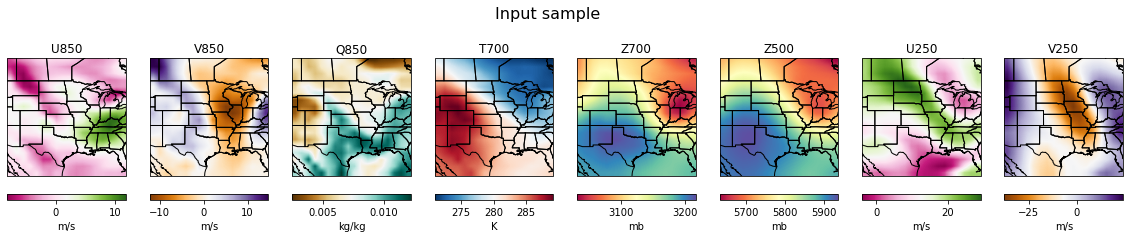

Mpi decoder:
-8.32975, 	12.71305, 	0.29337
-12.19165, 	18.11276, 	1.79205
0.00257, 	0.01294, 	0.00801
268.61725, 	287.77769, 	279.07401
3047.24025, 	3260.23146, 	3192.31948
5621.48431, 	5951.31060, 	5841.03267
-7.32420, 	28.71742, 	11.66728
-42.80572, 	24.79361, 	-6.60248



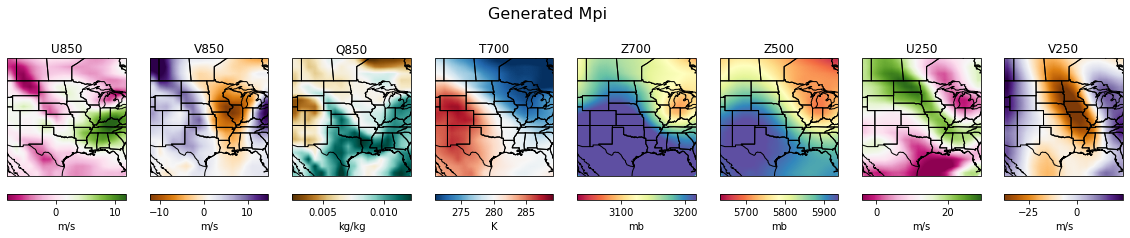

Era decoder:
-8.27409, 	11.75556, 	-0.08384
-12.26298, 	14.73671, 	0.10317
0.00244, 	0.01221, 	0.00758
270.83515, 	289.03541, 	280.37548
3030.04536, 	3216.90820, 	3143.75309
5623.52809, 	5936.07688, 	5821.58215
-4.03887, 	29.17792, 	13.28838
-37.47511, 	24.01549, 	-4.40051


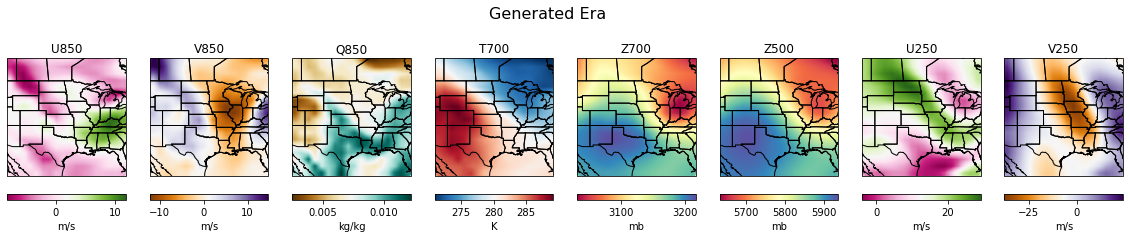

In [78]:
# Simple test
import matplotlib.pyplot as plt
mb = 1
#for ii in range(13514,13515,1):
for ii in [180]: #range(0,1,1):
    doy = ii % 365.25
    
    #input_img = samples[ii:ii+mb].cuda()
    input_img = samples[ii:ii+mb]
    

    
    # plot 8 vars
    input_img_denorm = input_img * (minmaxi_era[:,1]-minmaxi_era[:,0])[np.newaxis,:,np.newaxis,np.newaxis] + minmaxi_era[:,0][np.newaxis,:,np.newaxis,np.newaxis]
    # autoscale
    print(input_img.shape)
    vmin = [input_img_denorm[0][ii].min() for ii in range(8)]
    vmax = [input_img_denorm[0][ii].max() for ii in range(8)]
    print("Original:")
    for ii in range(8):
        print("%.5f, \t%.5f, \t%.5f" % (input_img_denorm[0][ii].min(), input_img_denorm[0][ii].max(), input_img_denorm[0][ii].mean()))
    print()
    #plot_8v_autoscale(np.array(input_img_denorm[0].detach()), 'foo')
    plot_8v_abs(np.array(input_img_denorm[0].detach()), 'Input sample', vmin, vmax)
        
    # mpi generator
    generated_img = generator3(generator(input_img))#.data.cpu()
    generated_img = generated_img.detach() * (minmaxi_mpi[:,1]-minmaxi_mpi[:,0])[np.newaxis,:,np.newaxis,np.newaxis] + minmaxi_mpi[:,0][np.newaxis,:,np.newaxis,np.newaxis]
    print("Mpi decoder:")
    #f, axarr = plt.subplots(1, 8, figsize = (20,20))
    for ii in range(8):
        #axarr[ii].imshow(generated_img[0][ii].detach())
        print("%.5f, \t%.5f, \t%.5f" % (generated_img[0][ii].detach().min(), generated_img[0][ii].detach().max(), generated_img[0][ii].detach().mean()))
    print()
    #plot_8v_autoscale(np.array(generated_img[0].detach()), 'foo')
    plot_8v_abs(np.array(generated_img[0].detach()), 'Generated Mpi', vmin, vmax)


        
    # era generator
    generated_img = generator2(generator(input_img))#.data.cpu()
    generated_img = generated_img.detach() * (minmaxi_era[:,1]-minmaxi_era[:,0])[np.newaxis,:,np.newaxis,np.newaxis] + minmaxi_era[:,0][np.newaxis,:,np.newaxis,np.newaxis]
    print("Era decoder:")
    for ii in range(8):
        print("%.5f, \t%.5f, \t%.5f" % (generated_img[0][ii].detach().min(), generated_img[0][ii].detach().max(), generated_img[0][ii].detach().mean()))
    #plot_8v_autoscale(np.array(generated_img[0].detach()), 'foo')
    plot_8v_abs(np.array(generated_img[0].detach()), 'Generated Era', vmin, vmax)



torch.Size([1, 9, 128, 128])
Original:
-8.25346, 	11.84916, 	-0.05003
-12.26590, 	14.71586, 	0.12090
0.00245, 	0.01219, 	0.00759
270.95841, 	289.15205, 	280.45557
3031.18957, 	3217.21219, 	3144.26632
5632.42673, 	5937.90583, 	5823.33469
-4.02163, 	29.20636, 	13.38165
-37.63547, 	24.15953, 	-4.50177

Mpi decoder:
-8.32975, 	12.71305, 	0.29337
-12.19165, 	18.11276, 	1.79205
0.00257, 	0.01294, 	0.00801
268.61725, 	287.77769, 	279.07401
3047.24025, 	3260.23146, 	3192.31948
5621.48431, 	5951.31060, 	5841.03267
-7.32420, 	28.71742, 	11.66728
-42.80572, 	24.79361, 	-6.60248



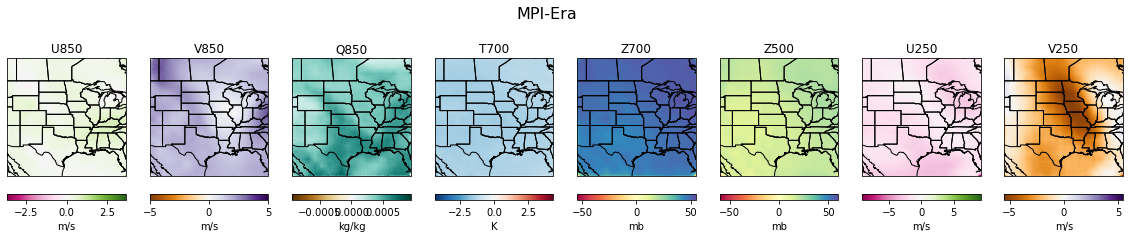

Era decoder:
-8.27409, 	11.75556, 	-0.08384
-12.26298, 	14.73671, 	0.10317
0.00244, 	0.01221, 	0.00758
270.83515, 	289.03541, 	280.37548
3030.04536, 	3216.90820, 	3143.75309
5623.52809, 	5936.07688, 	5821.58215
-4.03887, 	29.17792, 	13.28838
-37.47511, 	24.01549, 	-4.40051


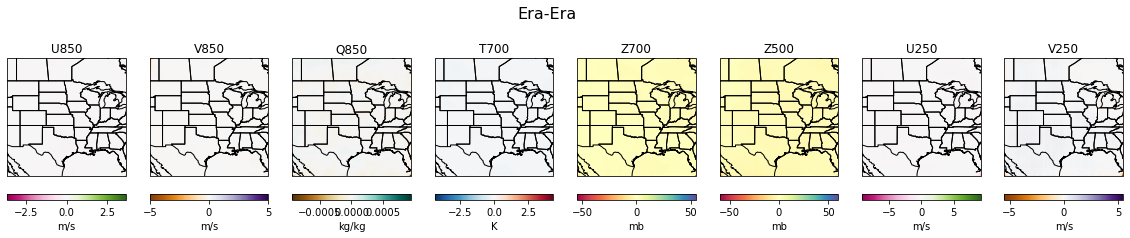

In [68]:
# diffs
# Simple test
import matplotlib.pyplot as plt
mb = 1
#for ii in range(13514,13515,1):
for ii in [180]: #range(0,1,1):
    doy = ii % 365.25
    
    #input_img = samples[ii:ii+mb].cuda()
    input_img = samples[ii:ii+mb]
    
    
    # input image
    input_img_denorm = input_img * (minmaxi_era[:,1]-minmaxi_era[:,0])[np.newaxis,:,np.newaxis,np.newaxis] + minmaxi_era[:,0][np.newaxis,:,np.newaxis,np.newaxis]
    # autoscale
    print(input_img.shape)
    print("Original:")
    for ii in range(8):
        print("%.5f, \t%.5f, \t%.5f" % (input_img_denorm[0][ii].min(), input_img_denorm[0][ii].max(), input_img_denorm[0][ii].mean()))
    print()
        
    # mpi generator
    generated_img = generator3(generator(input_img))#.data.cpu()
    generated_img = generated_img.detach() * (minmaxi_mpi[:,1]-minmaxi_mpi[:,0])[np.newaxis,:,np.newaxis,np.newaxis] + minmaxi_mpi[:,0][np.newaxis,:,np.newaxis,np.newaxis]
    print("Mpi decoder:")
    #f, axarr = plt.subplots(1, 8, figsize = (20,20))
    for ii in range(8):
        #axarr[ii].imshow(generated_img[0][ii].detach())
        print("%.5f, \t%.5f, \t%.5f" % (generated_img[0][ii].detach().min(), generated_img[0][ii].detach().max(), generated_img[0][ii].detach().mean()))
    print()
    #plot_8v_autoscale(np.array(generated_img[0].detach()), 'foo')
    diff1 = np.array(generated_img[0].detach()) - np.array(input_img_denorm[0])
    vmin = [diff1[ii].min() for ii in range(8)]
    vmax = [diff1[ii].max() for ii in range(8)]
    plot_8v_clim(diff1, 'MPI-Era', vmin, vmax)

        
    # era generator
    generated_img = generator2(generator(input_img))#.data.cpu()
    generated_img = generated_img.detach() * (minmaxi_era[:,1]-minmaxi_era[:,0])[np.newaxis,:,np.newaxis,np.newaxis] + minmaxi_era[:,0][np.newaxis,:,np.newaxis,np.newaxis]
    print("Era decoder:")
    for ii in range(8):
        print("%.5f, \t%.5f, \t%.5f" % (generated_img[0][ii].detach().min(), generated_img[0][ii].detach().max(), generated_img[0][ii].detach().mean()))
    #plot_8v_autoscale(np.array(generated_img[0].detach()), 'foo')
    diff2 = np.array(generated_img[0].detach()) - np.array(input_img_denorm[0])
    plot_8v_clim(diff2, 'Era-Era', vmin, vmax)



In [82]:
#######################
## Averages for Mays ##
#######################

#input_img = samples[0:1].cuda()
#print("input_img", input_img.shape)
#corrected_img = generator(input_img).data.cpu() 
#print("corrected_img", corrected_img.shape)

mb = 1

xplot = []
yplot = []
ymulti = []
raw = np.zeros((9,ires,ires))
mpi = np.zeros((9,ires,ires))
era = np.zeros((9,ires,ires))
count = 0

#for ii in range(0,mndays,mb):
for ii in range(0,11688,1):
    doy = ii % 365.25
    #if 1:
    #if doy >= 0 and doy <= 30:      # Dec
    if doy >= 120 and doy <= 150:   # May
        #print(doy, count)
        
        # ground truth
        input_img = samples[ii:ii+mb]  
        #input_img_denorm = input_img
        input_img_denorm = input_img * (minmaxi_era[:,1]-minmaxi_era[:,0])[np.newaxis,:,np.newaxis,np.newaxis] + minmaxi_era[:,0][np.newaxis,:,np.newaxis,np.newaxis]
        #input_img_denorm = input_img * (minmaxi_mpi[:,1]-minmaxi_mpi[:,0])[np.newaxis,:,np.newaxis,np.newaxis] + minmaxi_mpi[:,0][np.newaxis,:,np.newaxis,np.newaxis]
        raw += np.array(input_img_denorm)[0]

        # era generator
        generated_img = generator2(generator(input_img))#.data.cpu()
        generated_img = generated_img.detach() * (minmaxi_era[:,1]-minmaxi_era[:,0])[np.newaxis,:,np.newaxis,np.newaxis] + minmaxi_era[:,0][np.newaxis,:,np.newaxis,np.newaxis]
        #diff1 = np.array(generated_img[0].detach()) - np.array(input_img_denorm[0])
        era += np.array(generated_img[0].detach())

        # mpi generator
        generated_img = generator3(generator(input_img))#.data.cpu()
        generated_img = generated_img.detach() * (minmaxi_mpi[:,1]-minmaxi_mpi[:,0])[np.newaxis,:,np.newaxis,np.newaxis] + minmaxi_mpi[:,0][np.newaxis,:,np.newaxis,np.newaxis]
        #diff2 = np.array(generated_img[0].detach()) - np.array(input_img_denorm[0])
        mpi += np.array(generated_img[0].detach())

        count += 1

        
raw /= count       
mpi /= count
era /= count


In [83]:
mpi.shape, diff2.shape

((9, 128, 128), (9, 128, 128))

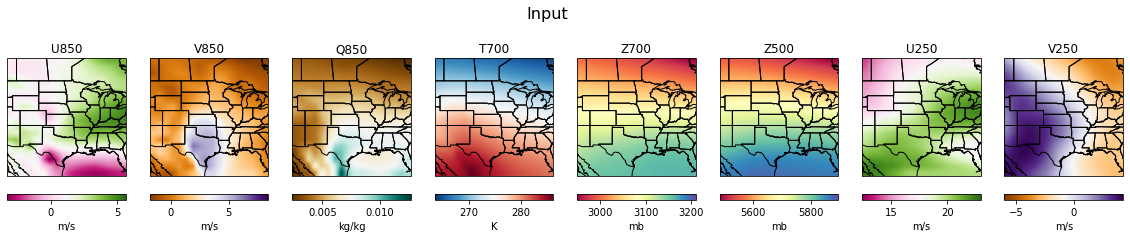

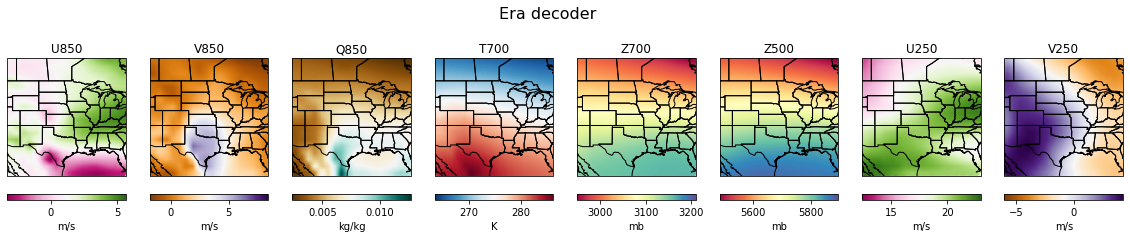

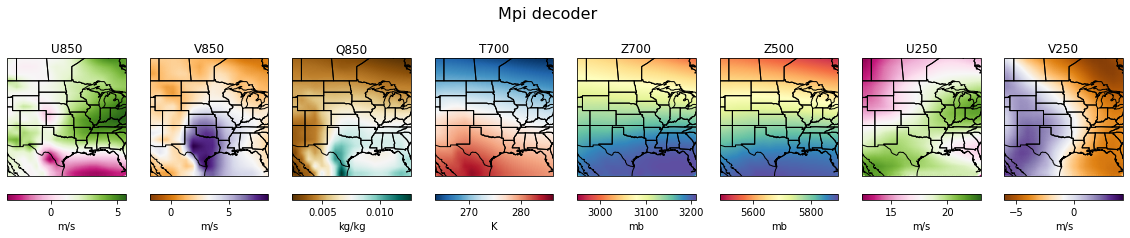

In [84]:
# Plot May averages 

# autoscale
vmin = [min(era[ii].min(),mpi[ii].min()) for ii in range(8)]
vmax = [max(era[ii].max(),mpi[ii].max()) for ii in range(8)]

plot_8v_abs(raw, 'Input', vmin, vmax)
plot_8v_abs(era, 'Era decoder', vmin, vmax)
plot_8v_abs(mpi, 'Mpi decoder', vmin, vmax)


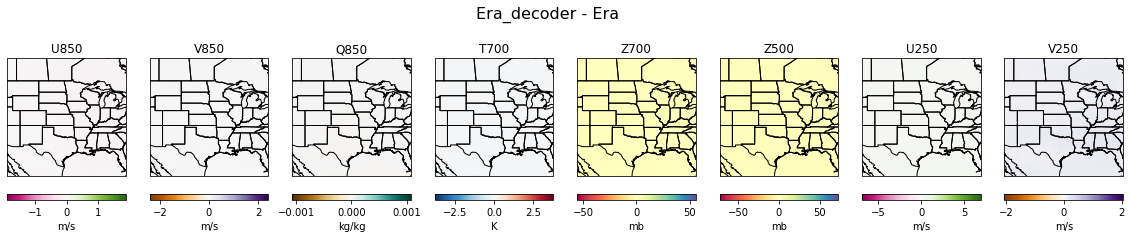

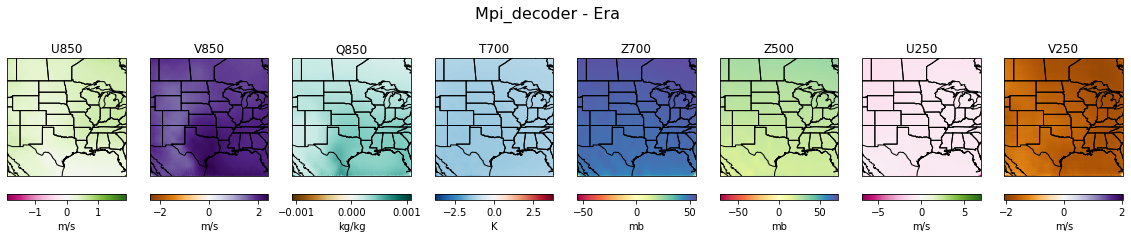

In [85]:
# Plot May averages error

# autoscale
vmin = [min((era[ii]-raw[ii]).min(),(mpi[ii]-raw[ii]).min()) for ii in range(8)]
vmax = [max((era[ii]-raw[ii]).max(),(mpi[ii]-raw[ii]).max()) for ii in range(8)]

plot_8v_clim(era-raw, 'Era_decoder - Era', vmin, vmax)
plot_8v_clim(mpi-raw, 'Mpi_decoder - Era', vmin, vmax)


In [17]:
test = generator3(generator(samples[0].view(1,9,ires,ires))) - samples[0].view(1,9,ires,ires)
print(test.shape)
print(test)


torch.Size([1, 9, 128, 128])
tensor([[[[-1.1302e-01, -7.2835e-02, -6.3635e-02,  ..., -4.0252e-02,
           -3.4976e-02, -2.7485e-02],
          [-2.2180e-01, -9.8743e-02, -9.0173e-02,  ..., -4.8926e-02,
           -2.8030e-02,  6.3426e-03],
          [-1.3752e-01, -8.5280e-02, -9.0093e-02,  ..., -5.3627e-02,
           -3.7308e-02, -6.9673e-02],
          ...,
          [-2.4031e-03, -1.6174e-02, -3.2179e-02,  ...,  2.4899e-01,
            2.7890e-01,  3.4719e-01],
          [-1.8329e-02, -1.0760e-02, -1.9335e-02,  ...,  1.5102e-02,
            2.3317e-01,  1.7110e-01],
          [-1.1940e-02,  1.1870e-02,  1.3840e-02,  ...,  3.4674e-01,
            3.4719e-01,  3.4719e-01]],

         [[ 4.0088e-02,  3.7896e-02,  4.8715e-02,  ..., -2.1739e-02,
           -2.7335e-02, -2.8537e-02],
          [ 8.2539e-02, -1.5745e-02, -1.2288e-02,  ..., -2.4897e-02,
           -3.0018e-02, -9.1752e-02],
          [ 3.1805e-02, -9.2010e-03, -5.0837e-03,  ..., -2.5754e-02,
           -4.2253e-02, -2.61